In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import sys
from tqdm import tqdm
from scipy.optimize import minimize
parent_dir = os.path.dirname(os.getcwd())
os.chdir(parent_dir)
print(parent_dir)
import mmars

In [ ]:
min_width, max_width, num_radars = 0, 0, 3
radar_models = [mmars.FmcwRadar(position=np.array([[pos_x,0]]), signalNoiseRatio=[10, 10], N_chirps=1) for pos_x in np.linspace(min_width, max_width, num_radars)]

In [ ]:
T_frame = .1
target_model = mmars.Target(start_position=np.array([[0.,5.]]), start_velocity=1., T_total=10., T_frame=T_frame)
target_model.generate_trajectory(trajectory_type="linear")
target_ground_truth = target_model.get_trajectory()

In [ ]:
mrblat_simulation = mmars.MRBLaT_Functions(radar_models[1], target_model)
mrblat_simulation.run()
mrblat_simulation.run_tracking()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001C280E77850> and <mmars.target.Target object at 0x000001C28F36F290>


100%|██████████| 100/100 [00:00<00:00, 854.17it/s]


In [ ]:
# HARDCODED MRBLaT
radar_model_01 = radar_models[0]
radar_model_02 = radar_models[1]
radar_model_03 = radar_models[2]

target_model = target_model

mrblat_simulation_01 = mmars.MRBLaT_Functions(radar_model_01, target_model)
mrblat_simulation_01.run()
mrblat_simulation_01_data = mrblat_simulation_01.get_data()
mrblat_simulation_02 = mmars.MRBLaT_Functions(radar_model_02, target_model)
mrblat_simulation_02.run()
mrblat_simulation_02_data = mrblat_simulation_02.get_data()
mrblat_simulation_03 = mmars.MRBLaT_Functions(radar_model_03, target_model)
mrblat_simulation_03.run()
mrblat_simulation_03_data = mrblat_simulation_03.get_data()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001C288CA7D50> and <mmars.target.Target object at 0x000001C28F36F290>


100%|██████████| 100/100 [00:00<00:00, 996.51it/s]


Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001C280E77850> and <mmars.target.Target object at 0x000001C28F36F290>


100%|██████████| 100/100 [00:00<00:00, 983.27it/s]

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001C28D3A5290> and <mmars.target.Target object at 0x000001C28F36F290>

100%|██████████| 100/100 [00:00<00:00, 825.97it/s]


In [ ]:
PHI_bar = PHI_bar_no_msg_parsing = np.array([[[target_ground_truth[0][0]], [target_ground_truth[1][0]],[target_ground_truth[2][0]], [target_ground_truth[3][0]]]])
PHI_bbar = PHI_bbar_no_msg_parsing = 0.01*np.eye(4)[np.newaxis,:,:]
Lambda_a = np.eye((4))*0.01
estimat_limit = 50
estimat_counter = 1

EPSILON_bar_01 = EPSILON_bar_02 = EPSILON_bar_03 = PHI_bar[0]
EPSILON_bbar_01 = EPSILON_bbar_02 = EPSILON_bbar_03 = PHI_bbar[0]

bound = [(-100,100), (0.1,100), (0.01, 10), (0.01, 10)]

T = np.array([[1,0,T_frame,0],[0,1,0,T_frame],[0,0,1,0],[0,0,0,1]])
T_T = T.T
T_inv = np.linalg.pinv(T)
G = np.array([[T_frame**2/2, 0, 0, 0],[0, T_frame**2/2, 0, 0],[0, 0, T_frame, 0],[0, 0, 0, T_frame]])
G_inv_T = np.linalg.pinv(G).T
G_inv = np.linalg.pinv(G)
lambda_a = np.eye(4)*.01

N_ite = 100
for frame_idx in range(1,mrblat_simulation_02.get_number_of_frames()):# tqdm(range(1,mrblat_simulation_02.get_number_of_frames())):
    data_fourier = np.fft.fft(mrblat_simulation_01_data[frame_idx],axis=-1).flatten()
    D_KL_res_01 = minimize(mrblat_simulation_01.D_KL, x0=(PHI_bar_no_msg_parsing[-1,0,0], PHI_bar_no_msg_parsing[-1,1,0], PHI_bbar_no_msg_parsing[-1,0,0], PHI_bbar_no_msg_parsing[-1,1,1]), bounds=bound, args=(data_fourier, PHI_bar_no_msg_parsing[-1,0,0], PHI_bar_no_msg_parsing[-1,1,0], (1,1,1,1), False), method='nelder-mead', options={'maxiter': 100})
    EPSILON_bar_01 = np.array([[D_KL_res_01.x[0]], [D_KL_res_01.x[1]], [0],[0]])
    EPSILON_bbar_01 = np.array([[D_KL_res_01.x[2], 0, 0, 0],[0, D_KL_res_01.x[3], 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]])
    
    if estimat_counter < estimat_limit:
        estimat_counter += 1

    PHI_bar = np.concatenate((PHI_bar, EPSILON_bar_01[np.newaxis,:,:]), axis=0)
    PHI_bbar = np.concatenate((PHI_bbar, EPSILON_bbar_01[np.newaxis,:,:]), axis=0)
    # PHI_bar = np.concatenate((PHI_bar, np.zeros((1, 4, 1))), axis=0)
    # PHI_bbar = np.concatenate((PHI_bbar, np.zeros((1, 4, 4))), axis=0)
    PHI_bar_no_msg_parsing = np.concatenate((PHI_bar_no_msg_parsing, EPSILON_bar_01[np.newaxis,:,:]), axis=0)
    PHI_bbar_no_msg_parsing = np.concatenate((PHI_bbar_no_msg_parsing, EPSILON_bbar_01[np.newaxis,:,:]), axis=0)

    estimat_range = range(PHI_bar.shape[0]-estimat_counter, PHI_bar.shape[0])

    for n_ite in range(N_ite):
        for n_estimate in estimat_range:
            if n_estimate == 0:
                eps_np1_to_n_mean = T_inv@PHI_bar[n_estimate+1] 
                eps_np1_to_n_cov = T_T@G_inv_T@lambda_a@G_inv@T 
                plt.pause(1)
                PHI_bbar[n_estimate] = np.linalg.pinv(
                    np.linalg.pinv(EPSILON_bbar_01)
                    +np.linalg.pinv(eps_np1_to_n_cov)
                    )
                PHI_bar[n_estimate] = PHI_bbar[n_estimate]@(
                    np.linalg.pinv(EPSILON_bbar_01)@EPSILON_bar_01 
                    +np.linalg.pinv(eps_np1_to_n_cov)@eps_np1_to_n_mean
                    )
                # print("state 1")
            elif n_estimate == PHI_bar.shape[0]-1:
                esp_nm1_to_n_mean = T@PHI_bar[n_estimate-1] 
                esp_nm1_to_n_cov = G_inv_T@lambda_a@G
                PHI_bbar[n_estimate] = np.linalg.pinv(
                    np.linalg.pinv(EPSILON_bbar_01)
                    +np.linalg.pinv(esp_nm1_to_n_cov)
                    )
                PHI_bar[n_estimate] = PHI_bbar[n_estimate]@(
                    np.linalg.pinv(EPSILON_bbar_01)@EPSILON_bar_01 
                    +np.linalg.pinv(esp_nm1_to_n_cov)@esp_nm1_to_n_mean
                    )
                # print("state 2")
            else:
                esp_nm1_to_n_mean = T@PHI_bar[n_estimate-1] 
                esp_nm1_to_n_cov = G_inv_T@lambda_a@G
                eps_np1_to_n_mean = T_inv@PHI_bar[n_estimate+1] 
                eps_np1_to_n_cov = T_T@G_inv_T@lambda_a@G_inv@T 
                PHI_bbar[n_estimate] = np.linalg.pinv(
                    np.linalg.pinv(EPSILON_bbar_01)
                    +np.linalg.pinv(esp_nm1_to_n_cov)
                    +np.linalg.pinv(eps_np1_to_n_cov)
                    )
                PHI_bar[n_estimate] = PHI_bbar[n_estimate]@(
                    np.linalg.pinv(EPSILON_bbar_01)@EPSILON_bar_01 
                    +np.linalg.pinv(esp_nm1_to_n_cov)@esp_nm1_to_n_mean
                    +np.linalg.pinv(eps_np1_to_n_cov)@eps_np1_to_n_mean
                    )
                # print("state 3")
        if len(PHI_bar) > 1:
            alpha = len(PHI_bar) + 1 
            beta = 0
            for _n_ in estimat_range:
                beta += np.linalg.norm(G_inv@(PHI_bar[_n_]-T@PHI_bar[_n_-1]))**2 + G_inv@(PHI_bbar[_n_] + T@PHI_bbar[_n_-1]@T_T)@G_inv_T
            lambda_a = np.linalg.pinv(beta/alpha)
    
    
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(target_ground_truth[0], target_ground_truth[1], label="Ground Truth", color="black", marker=".", s=1)
    ax[0].scatter(PHI_bar_no_msg_parsing[:,0,0], PHI_bar_no_msg_parsing[:,1,0], label="Estimate - MSG.PARSING", color="blue", marker="x",s=100)
    ax[0].scatter(PHI_bar[:,0,0], PHI_bar[:,1,0], label="Estimate - DKL", color="red", marker="+",s=100)
    ax[0].set_xlim(-10, 10)
    ax[0].set_ylim(0, 20)
    ax[0].set_aspect('equal')
    ax[0].set_title("Ground Truth vs Estimate - Position")
    ax[0].set_xlabel("x [m]")
    ax[0].set_ylabel("y [m]")
    ax[0].legend()

    
    ax[1].plot(PHI_bar[:,2,0])
    ax[1].plot(PHI_bar[:,3,0])
    ax[1].set_ylim(-.1, 1.1)
    ax[1].set_title("Estimate - Velocity")
    ax[1].set_xlabel("Frame")
    ax[1].set_ylabel("Velocity [m/s]")
    ax[1].legend(["Vx", "Vy"])

    plt.tight_layout()
    plt.show()

In [ ]:
print(PHI_bar)

[[[ 7.94422376e+01]
  [ 7.94422376e+01]
  [ 1.19163356e+01]
  [ 1.19163356e+01]]

 [[ 7.60625933e+01]
  [ 7.60625933e+01]
  [ 1.03341891e+02]
  [ 1.03341891e+02]]

 [[ 8.16921593e+01]
  [ 8.16921593e+01]
  [ 1.97434354e+02]
  [ 1.97434354e+02]]

 [[ 1.05869197e+02]
  [ 1.05869197e+02]
  [ 1.08762298e+02]
  [ 1.08762298e+02]]

 [[ 1.28182192e+02]
  [ 1.28182192e+02]
  [-1.19973000e+02]
  [-1.19973000e+02]]

 [[ 1.04879455e+02]
  [ 1.04879455e+02]
  [ 1.06135736e+02]
  [ 1.06135736e+02]]

 [[ 1.99359567e+02]
  [ 1.99359567e+02]
  [-1.57119503e+03]
  [-1.57119503e+03]]

 [[-5.83268912e+02]
  [-5.83268912e+02]
  [ 1.09389845e+04]
  [ 1.09389845e+04]]

 [[ 4.81268179e+03]
  [ 4.81268179e+03]
  [-7.51020604e+04]
  [-7.51020604e+04]]

 [[-3.24549292e+04]
  [-3.24549292e+04]
  [ 5.20046038e+05]
  [ 5.20046038e+05]]

 [[ 2.25853080e+05]
  [ 2.25853080e+05]
  [-3.60602208e+06]
  [-3.60602208e+06]]

 [[-1.56551900e+06]
  [-1.56551899e+06]
  [ 2.50093753e+07]
  [ 2.50093753e+07]]

 [[ 1.08592734e+

In [ ]:
ddddd

NameError: name 'ddddd' is not defined

In [ ]:
PHI_bar = np.array([[target_ground_truth[0][0], target_ground_truth[1][0],target_ground_truth[2][0], target_ground_truth[3][0]]]) # First position, (x,y) and (vx,vy) at t=0
PHI_bbar = 0.01*np.eye(4)[np.newaxis,:,:] # Initial guess for the covariance matrix of the target model. The position (x,y) and the variance (eps_barbar_x, eps_barbar_y) at t=0
PHI_bar_no_msg_parsing = PHI_bar
PHI_bbar_no_msg_parsing = PHI_bbar
EPSILON_bar_01 = EPSILON_bar_02 = EPSILON_bar_03 =  np.array([[PHI_bar[0][0], PHI_bar[0][1], 0, 0]])
EPSILON_bbar_01 = EPSILON_bbar_02 = EPSILON_bbar_03 =  np.array([[[1e-1, 0, 0, 0],[0, 1e-1, 0, 0],[0, 0, 1e-10, 0],[0, 0, 0, 1e-10]]])
bound = [(-100,100), (0.1,100), (0.01, 10), (0.01, 10)]
N_ite = 1

T = np.array([[1,0,T_frame,0],[0,1,0,T_frame],[0,0,1,0],[0,0,0,1]])
T_T = T.T
T_inv = np.linalg.pinv(T)
G = np.array([[T_frame**2/2, 0, 0, 0],[0, T_frame**2/2, 0, 0],[0, 0, T_frame, 0],[0, 0, 0, T_frame]])
G_inv_T = np.linalg.pinv(G).T
G_inv = np.linalg.pinv(G)
lambda_a = np.eye(4)*.01

N_estimates = 1
regularisation = 0

N_end = 0
N_start = 0

for frame_idx in tqdm(range(1,mrblat_simulation_02.get_number_of_frames())):
    x0 = [EPSILON_bar_01[-1][0], EPSILON_bar_01[-1][1], EPSILON_bbar_01[-1][0,0], EPSILON_bbar_01[-1][1,1]]
    data_fourier = np.fft.fft(mrblat_simulation_01_data[frame_idx],axis=-1).flatten()
    D_KL_res_01 = minimize(mrblat_simulation_01.D_KL, x0=x0, bounds=bound, args=(data_fourier, EPSILON_bar_01[-1][0], EPSILON_bar_01[-1][1], (1,1,1,1), False), method='nelder-mead', options={'maxiter': 100})
    
    EPSILON_bar_01 = np.vstack((EPSILON_bar_01, np.array([D_KL_res_01.x[0], D_KL_res_01.x[1], regularisation, regularisation])))
    EPSILON_bbar_01 = np.vstack((EPSILON_bbar_01, np.array([[[D_KL_res_01.x[2], 0, 0, 0],[0, D_KL_res_01.x[3], 0, 0],[0, 0, regularisation, 0],[0, 0, 0, regularisation]]])))

    PHI_bar = np.vstack((PHI_bar, np.array([[D_KL_res_01.x[0], D_KL_res_01.x[1], 0, 0]]) ))
    PHI_bbar = np.vstack((PHI_bbar, np.array([[D_KL_res_01.x[2], 0, 0, 0],[0,D_KL_res_01.x[3],0,0],[0,0,0.0,0],[0,0,0,0]])[np.newaxis,:,:] ))
    PHI_bar_no_msg_parsing = np.vstack((PHI_bar_no_msg_parsing, np.array([[D_KL_res_01.x[0], D_KL_res_01.x[1], 0, 0]]) ))
    PHI_bbar_no_msg_parsing = np.vstack((PHI_bbar_no_msg_parsing, np.array([[D_KL_res_01.x[2], 0, 0, 0],[0,D_KL_res_01.x[3],0,0],[0,0,0,0],[0,0,0,0]])[np.newaxis,:,:] ))

    if N_estimates < 20:
        N_estimates += 1

    N_estimates_range = range(len(PHI_bar)-N_estimates-1, len(PHI_bar)-1)
    
    for ite in range(N_ite):
        for n_estimates in N_estimates_range:
            if (n_estimates > 0) and (n_estimates < len(PHI_bar)-1):
                eps_np1_to_n_mean = T_inv@PHI_bar[n_estimates+1] 
                esp_nm1_to_n_mean = T@PHI_bar[n_estimates-1] 
                eps_np1_to_n_cov = T_T@G_inv_T@lambda_a@G_inv@T 
                esp_nm1_to_n_cov = G_inv_T@lambda_a@G

                PHI_bbar[n_estimates] = np.linalg.pinv(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])
                    +np.linalg.pinv(eps_np1_to_n_cov)
                    +np.linalg.pinv(esp_nm1_to_n_cov)
                    )
                
                PHI_bar[n_estimates] = PHI_bbar[n_estimates]@(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])@EPSILON_bar_01[n_estimates] 
                    +np.linalg.pinv(eps_np1_to_n_cov)@eps_np1_to_n_mean
                    +np.linalg.pinv(esp_nm1_to_n_cov)@esp_nm1_to_n_mean
                    )
                
            elif (n_estimates < len(PHI_bar)-1):
                N_start += 1
                # print("N_start ", N_start)
                eps_np1_to_n_mean = T_inv@PHI_bar[n_estimates+1]
                eps_np1_to_n_cov = T_T@G_inv_T@lambda_a@G_inv@T 

                PHI_bbar[n_estimates] = np.linalg.pinv(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])
                    +np.linalg.pinv(eps_np1_to_n_cov) 
                    )
                PHI_bar[n_estimates] = PHI_bbar[n_estimates]@(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])@EPSILON_bar_01[n_estimates] 
                    +np.linalg.pinv(eps_np1_to_n_cov)@eps_np1_to_n_mean 
                    )
            elif (n_estimates > 0):
                N_end += 1
                print("N_end ", N_end)
                esp_nm1_to_n_mean = T@PHI_bar[n_estimates-1]
                esp_nm1_to_n_cov = G_inv_T@lambda_a@G

                PHI_bbar[n_estimates] = np.linalg.pinv(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])
                    +np.linalg.pinv(esp_nm1_to_n_cov) 
                    )
                PHI_bar[n_estimates] = PHI_bbar[n_estimates]@(
                    np.linalg.pinv(EPSILON_bbar_01[n_estimates])@EPSILON_bar_01[n_estimates] 
                    +np.linalg.pinv(esp_nm1_to_n_cov)@esp_nm1_to_n_mean 
                    )
            
        if len(PHI_bar) > 1:
            alpha = len(PHI_bar) + 1 
            beta = 0
            for _n_ in N_estimates_range:
                beta += np.linalg.norm(G_inv@(PHI_bar[_n_]-T@PHI_bar[_n_-1]))**2 + G_inv@(PHI_bbar[_n_] + T@PHI_bbar[_n_-1]@T_T)@G_inv_T
            lambda_a = np.linalg.pinv(beta/alpha)
        

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:27<00:00,  3.61it/s]


(100, 4)


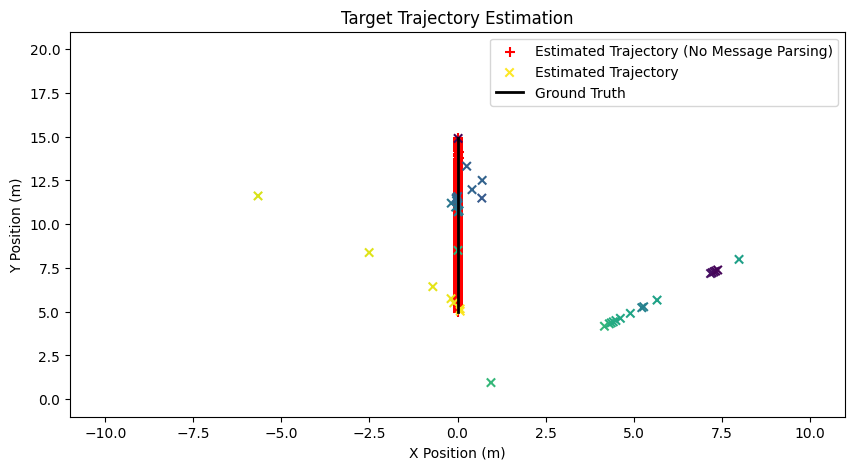

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(PHI_bar_no_msg_parsing[:,0], PHI_bar_no_msg_parsing[:,1], label='Estimated Trajectory (No Message Parsing)', marker = '+', s=50, color='red')#, cmap='viridis', c=np.linspace(0,1,len(PHI_bar_no_msg_parsing[:,0])))
ax.scatter(PHI_bar[:,0], PHI_bar[:,1], label='Estimated Trajectory', cmap='viridis', marker='x', c=np.linspace(1,0,len(PHI_bar[:,0])))#, s=50, color='blue')#
ax.plot(target_ground_truth[0], target_ground_truth[1], label='Ground Truth', color='black', linewidth=2)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_title('Target Trajectory Estimation')
ax.set_xlim(-11, 11)
ax.set_ylim(-1, 21)
ax.legend()


print(PHI_bar.shape)


In [ ]:
PHI_bar

array([[ 7.57520710e-02,  5.02977558e+00, -1.05678689e-09,
        -1.05497856e-09],
       [ 7.50112534e-02,  5.16226244e+00, -2.53915787e-04,
        -6.33347034e-03],
       [-1.08632721e-01,  5.50261965e+00,  8.60651513e-03,
        -2.30625206e-02],
       [-1.83492832e-01,  5.74626344e+00,  1.42504266e-02,
        -3.72179253e-02],
       [-7.01066809e-01,  6.43080606e+00,  3.97559871e-02,
        -7.11869673e-02],
       [-2.50856499e+00,  8.38009114e+00,  1.31917772e-01,
        -1.70595491e-01],
       [-5.66264777e+00,  1.16167070e+01,  2.87988769e-01,
        -3.30986599e-01],
       [-1.14905452e+01,  1.74007645e+01,  6.05739844e-01,
        -6.46760699e-01],
       [-2.75461060e+01,  3.31979808e+01,  1.39856718e+00,
        -1.42687589e+00],
       [ 2.50052512e+01, -1.99649382e+01, -1.38672188e+00,
         1.38884979e+00],
       [ 5.49299730e+01, -4.88562281e+01, -2.86378206e+00,
         2.81424902e+00],
       [ 4.25106702e+01, -3.63880255e+01, -2.20951450e+00,
      